In [1]:
import os
os.chdir("/Users/avitalvasiliev/Documents/NeuroGenomics/final_proj/part1")
print("Working directory:", os.getcwd())

Working directory: /Users/avitalvasiliev/Documents/NeuroGenomics/final_proj/part1


Build transcript-to-gene mapping from GTF file

In [2]:
import gzip
transcript_to_gene = {}

file1 = gzip.open('Mus_musculus.GRCm39.110.gtf.gz', 'rt')
for line in file1:
    if line.startswith('#'):
        continue
    fields = line.strip().split('\t')
    if len(fields) < 9:
        continue
    attrs = fields[8]
    gene_id = None
    transcript_id = None
    gene_name = None
    
    for attr in attrs.split(';'):
        attr = attr.strip()
        if attr.startswith('gene_id'):
            gene_id = attr.split('"')[1]
        elif attr.startswith('transcript_id'):
            transcript_id = attr.split('"')[1]
        elif attr.startswith('gene_name'):
            gene_name = attr.split('"')[1]
    
    if transcript_id and gene_id:
        transcript_to_gene[transcript_id] = gene_name if gene_name else gene_id

file1.close()
print(f"Found {len(transcript_to_gene)} transcripts")

Found 149547 transcripts


Load Kallisto output and sum counts to gene level


In [9]:
import pandas as pd

gene_counts = {}
# read kallisto output
for sample in ['C1', 'C2', 'C3', 'KO1', 'KO2', 'KO3']:
    abundance_file = f'{sample}_results/abundance.tsv'
    abundance_df = pd.read_csv(abundance_file, sep='\t')
    print(f"Sample: {sample}")
    print(abundance_df.head(5))
    print("total estimated counts:", abundance_df['est_counts'].sum())
    print("total TPM:", abundance_df['tpm'].sum())
    sample_gene_counts = {}
    for idx, row in abundance_df.iterrows():
        transcript = row['target_id'].split('.')[0]  # remove version
        count = row['est_counts']

        if transcript in transcript_to_gene:
            gene = transcript_to_gene[transcript]
            if gene not in sample_gene_counts:
                sample_gene_counts[gene] = 0
            sample_gene_counts[gene] += count
    
    gene_counts[sample] = sample_gene_counts
gene_counts_df = pd.DataFrame(gene_counts).fillna(0).round().astype(int)
gene_counts_df.to_csv('gene_counts.csv')


Sample: C1
              target_id  length  eff_length  est_counts  tpm
0  ENSMUST00000196221.2       9     4.54821         0.0  0.0
1  ENSMUST00000179664.2      11     5.14355         0.0  0.0
2  ENSMUST00000177564.2      16     6.37474         0.0  0.0
3  ENSMUST00000178537.2      12     5.41797         0.0  0.0
4  ENSMUST00000178862.2      14     5.92331         0.0  0.0
total estimated counts: 131979904.50177434
total TPM: 999999.9403521828
Sample: C2
              target_id  length  eff_length  est_counts  tpm
0  ENSMUST00000196221.2       9     4.54821         0.0  0.0
1  ENSMUST00000179664.2      11     5.14355         0.0  0.0
2  ENSMUST00000177564.2      16     6.37474         0.0  0.0
3  ENSMUST00000178537.2      12     5.41797         0.0  0.0
4  ENSMUST00000178862.2      14     5.92331         0.0  0.0
total estimated counts: 61039869.34916854
total TPM: 1000000.0394024596
Sample: C3
              target_id  length  eff_length  est_counts  tpm
0  ENSMUST00000196221.2       

Differential expression analysis with pyDESeq2

In [10]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
# define conditions
count_matrix = pd.read_csv('gene_counts.csv', index_col=0)
conditions = pd.DataFrame({
    'condition': ['control', 'control', 'control', 'knockout', 'knockout', 'knockout']
}, index=['C1', 'C2', 'C3', 'KO1', 'KO2', 'KO3'])
# run DESeq2
dds = DeseqDataSet(counts=count_matrix.T, metadata=conditions, design_factors='condition')
dds.deseq2()
# get results
stat_res = DeseqStats(dds, contrast=['condition', 'control', 'knockout'])
stat_res.summary()
results = stat_res.results_df


Using None as control genes, passed at DeseqDataSet initialization


/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_6296/768018490.py:9: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts=count_matrix.T, metadata=conditions, design_factors='condition')
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 6.39 seconds.

Fitting dispersion trend curve...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 5.02 seconds.

Fitting LFCs...
... done in 2.91 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition control vs knockout
         baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Trdd1    0.000000             NaN       NaN       NaN       NaN       NaN
Trdd2    0.000000             NaN       NaN       NaN       NaN       NaN
Trbd1    0.000000             NaN       NaN       NaN       NaN       NaN
Trbd2    0.000000             NaN       NaN       NaN       NaN       NaN
Ighd4-1  0.000000             NaN       NaN       NaN       NaN       NaN
...           ...             ...       ...       ...       ...       ...
Gm1980   5.466727       -2.126191  2.022257 -1.051395  0.293077  0.999835
Gm16362  0.000000             NaN       NaN       NaN       NaN       NaN
Gm52953  0.000000             NaN       NaN       NaN       NaN       NaN
Gm13711  0.000000             NaN       NaN       NaN       NaN       NaN
Gm52947  0.000000             NaN       NaN       NaN       NaN       NaN

[35957 rows x 6 columns]


... done in 1.60 seconds.



Verify negative binomial assumption

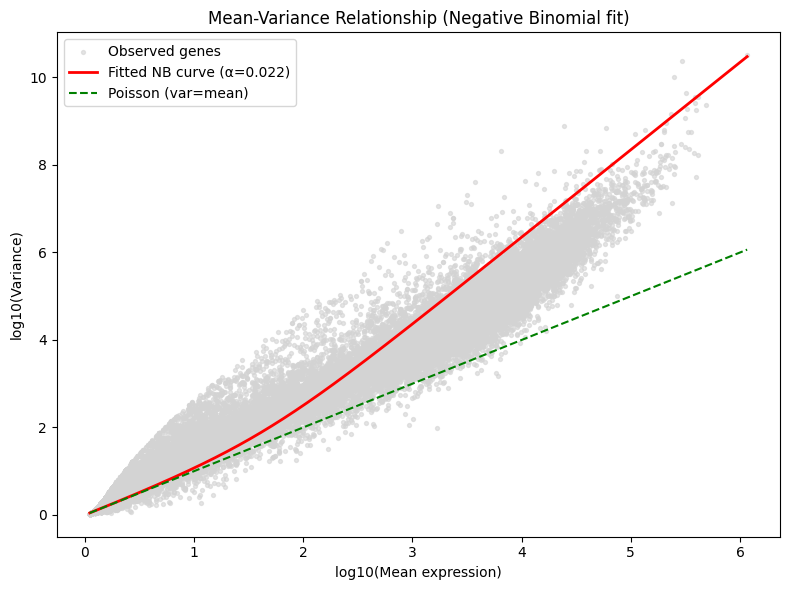

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

normed_counts = dds.layers['normed_counts']
means = normed_counts.mean(axis=0)
variances = normed_counts.var(axis=0)

# remove zeros
mask = means > 0
means_f = means[mask]
vars_f = variances[mask]

# negative binomial model
def neg_binom(mu, alpha):
    return mu + alpha * mu**2

# least squares fit
popt, _ = curve_fit(neg_binom, means_f, vars_f, p0=[0.1])
alpha_fit = popt[0]

# sort for smooth curve
sort_idx = np.argsort(means_f)
x_sorted = means_f[sort_idx]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(np.log10(means_f + 1), np.log10(vars_f + 1), 
           alpha=0.6, s=8, color='lightgray', label='Observed genes')
ax.plot(np.log10(x_sorted + 1), np.log10(neg_binom(x_sorted, alpha_fit) + 1), 
        color='red', linewidth=2, label=f'Fitted NB curve (α={alpha_fit:.3f})')
ax.plot(np.log10(x_sorted + 1), np.log10(x_sorted + 1), 
        color='green', linewidth=1.5, linestyle='--', label='Poisson (var=mean)')

ax.set_xlabel('log10(Mean expression)')
ax.set_ylabel('log10(Variance)')
ax.set_title('Mean-Variance Relationship (Negative Binomial fit)')
ax.legend()

plt.tight_layout()
plt.show()


Filter significant genes

In [12]:
# remove genes with NaN (no counts)
results_clean = results.dropna()
print(f"Total genes tested: {len(results_clean)}")
# filter significant genes (padj < 0.05)
significant = results_clean[results_clean['padj'] < 0.05]
print(f"Significant genes (padj < 0.05): {len(significant)}")
higher_in_knockout = significant[significant['log2FoldChange'] < 0]
print(f"Higher in knockout: {len(higher_in_knockout)}")
lower_in_knockout = significant[significant['log2FoldChange'] > 0]
print(f"Higher in control: {len(lower_in_knockout)}")


Total genes tested: 19754
Significant genes (padj < 0.05): 49
Higher in knockout: 23
Higher in control: 26


In [13]:
print("Top Genes Higher in Control:")
top_ctrl = lower_in_knockout.sort_values('padj')
print(top_ctrl[['baseMean', 'log2FoldChange', 'padj']])

print("Top Genes Higher in Knockout:")
top_ko = higher_in_knockout.sort_values('padj')
print(top_ko[['baseMean', 'log2FoldChange', 'padj']])


Top Genes Higher in Control:
               baseMean  log2FoldChange          padj
Gtf2i      25585.239056        0.698661  1.851373e-27
Neurod6     5689.080170        0.813529  5.154498e-16
Cnp        66822.208134        0.430445  1.144181e-07
Mag        31413.533602        0.453119  4.047499e-07
Mog        14185.430836        0.429855  6.146091e-06
Myl4        2973.875846        0.755022  7.086244e-06
Fibcd1      3001.560717        0.638824  1.340458e-05
Mobp      108874.720293        0.565912  8.686835e-05
Cldn11     37892.990527        0.390339  1.222827e-04
Plp1      327321.111171        0.360838  3.525515e-04
Wnt7b       5187.424195        0.352333  1.114721e-03
Actg-ps1      73.764654        2.973079  1.180547e-03
Mbp       320207.946015        0.521044  1.199004e-03
Trf        31686.314502        0.474372  1.224487e-03
Gjc2        3122.504876        0.438151  1.715124e-03
Gsn        18128.600008        0.395085  1.912912e-03
Herc6       1094.124383        0.550087  2.306300e-03

Save results

In [14]:
results_clean.to_csv('deseq2_results.csv')
significant.to_csv('significant_genes.csv')